## Hyperplane folding.

The following code runs the algorithm from the paper:
*Hyperplane folding - a way to increase the margin in Support Vector Machines
*Lars Lundberg, Håkan Lennerstad, Eva Garcia-Martin, Niklas Lavesson and Veselka Boeva

It does the following:
1. Apply SVM in a dataset
2. Select the primary support vector
3. Divide the points into two, ones to the left of the support vector (forming an orthogonal line with the hyperplane) and the other ones to the right of the support vector
4. Apply two SVM on each new set of points
5. Rotate one side an angle a. 
6. The margin has thus increased from the initial one. 

In [104]:
"""
Simulation functions
"""

def generate_point(center, radius):
    #Generate a random vector on the unit circle (length 1)
    ang = uniform(0, 2*pi)
    v = np.array([cos(ang), sin(ang)])
 
    # Generate a normally distributed length
    #(mean = 0, so the length can be negative)
    l = radius + 1
    while abs(l) > radius:
        l = normalvariate(0, radius)
    return center + l * v


def generate_points(centers, points_per_circle, radius):
    X = list()
    Y = list()
    count = 1
    
    for center in centers:
        for i in range(points_per_circle):
            X.append(generate_point(center, radius))
            if count%2:
                Y.append(0)
            else:
                Y.append(1)
        count += 1
        
    X=np.array(X)
    Y=np.array(Y)
    return (X,Y)

def get_margin(clf):
    w = clf.coef_[0]
    a = -w[0] / w[1]
    s_vectors = clf.support_vectors_
    intrc_up = (s_vectors[-1][1] - a * s_vectors[-1][0])
    intrc_down = (s_vectors[0][1] - a * s_vectors[0][0])
    margin = (abs(intrc_up - intrc_down))/(math.sqrt(1+(a*a)))
    return margin

def plot_SVM(clf,x,y, should_plot):
    if should_plot: 
        w = clf.coef_[0]
        a = -w[0] / w[1]
        xx = np.linspace(x[:,0].min(),x[:,0].max())
        intercept = -(clf.intercept_[0]) / w[1]
        s_vectors = clf.support_vectors_

        # Margin
        intrc_up = (s_vectors[-1][1] - a * s_vectors[-1][0])
        intrc_down = (s_vectors[0][1] - a * s_vectors[0][0])
        yy = a * xx + intercept
        yy_up = a * xx + intrc_up
        yy_down = a * xx + intrc_down

        pdf = PdfPages('SVM' + str(time.clock()) + '.pdf')
        fig=figure(figsize=(6,4))
        
        plt.plot(xx, yy, 'k-')
        plt.plot(xx, yy_down, 'k--')
        plt.plot(xx, yy_up, 'k--')

        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],s=80, facecolors='none')
        plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Paired)
        plt.axis('tight')
        plt.show()
        
        pdf.savefig(fig) # note the format='pdf' argument!
        pdf.close()
    
def get_support_vector(X, Y, supp):
    
    s=0
    supp_v=0
    for i in supp:
        s += Y[i]
    for n in supp:
        if Y[n] == 1 and s == 1:
            return X[n]
        if Y[n] == 0 and s== 2:
            return X[n]
        
def point_vs_othline(point, supp,  a ): 
    t= (point[0] - supp[0])/(-a)
    if point[1] <= supp[1] + t:
        return "higher/right"
    else:
        return "lower/left"
    
def split2 (X,Y, clf, prime_sv):
    r"""
    Splitting the points in X and Y, based on an orthogonal line to the hyperplane
    obtained by the classifier clf
    
    return: both sets of points
    """
    suppsum = 0
    set1x=list()
    set2x=list()
    set1y=list()
    set2y=list()
    
    for item in clf.n_support_:
        suppsum+=item
    if suppsum >= 3: 
        w = clf.coef_[0]
        a = -w[0] / w[1]
        i=0
        for item in X:
            if (item[0]==prime_sv[0]) and (item[1]==prime_sv[1]):
                set1x.append(item)
                set1y.append(Y[i])
                set2x.append(item)
                set2y.append(Y[i])
            elif point_vs_othline(item,prime_sv,a ) == "higher/right":
                set2x.append(item)
                set2y.append(Y[i])
            elif point_vs_othline(item,prime_sv,a) == "lower/left":
                set1x.append(item)
                set1y.append(Y[i])
            else:
                print "There is something wrong. Point is not either higher nor lower"
            i+=1
    return [set1x, set1y, set2x, set2y]


def folding_point(clf1, clf2):
    
    w1 = clf1.coef_[0]
    a1 = -w1[0] / w1[1]
    intercept1= -(clf1.intercept_[0]) / w1[1]
    
    w2 = clf2.coef_[0]
    a2 = -w2[0] / w2[1]
    intercept2= -(clf2.intercept_[0]) / w2[1]
    
    xf = (intercept2-intercept1)/(a1-a2)
    yf = xf*a1 + intercept1
    
    angle = np.arctan(a1) - np.arctan(a2)
    return [xf,yf] , angle
    
def remove_supp (sx, sy, supp):
    
    index=0
    while sx[index][0] != supp[0] and sx[index][1] != supp[1]:
        index+=1
    sx = np.delete(sx,index, 0)
    sy = np.delete(sy,index)
    
    return sx,sy
    
def points_rotated(X, f_point, angle):
    
    i=0
    XR = np.zeros(X.shape)
    # 1. 2. and 3.
    for item in X:
        XR[i][0] = item[0] - f_point[0] 
        XR[i][1] = item[1] - f_point[1]
        
        x_p = np.cos(angle)*XR[i][0] - np.sin(angle)*XR[i][1]
        y_p = np.sin(angle)*XR[i][0] + np.cos(angle)*XR[i][1]
        
        XR[i][0] = x_p + f_point[0]
        XR[i][1] = y_p + f_point[1]
        i+=1
    return XR

def get_clf():
    """
    Return the classifier, so that we can test different classifiers and not only one
    We don't need to change the instance everywhere, which outputs many errors due to the manual
    change that it requires. 

    """
     
    C = 1000000000
    return svm.SVC(kernel='linear', C = C) 

def rotation(x,y,clf, plot = False):
    """
    Gets the main support vector. 
    Divides the dataset into 2,based on the orthogonal line 
    to the plane and the main support vector. 
    Apply SVM on both sides, rotate the one with the greatest margin. 
    """
#     print len(x), len(y), clf.support_
    prime_sv = get_support_vector(x,y, clf.support_ )
    set1x, set1y, set2x, set2y = split2 (x, y, clf, prime_sv)
#     clf_s1 = svm.NuSVC(kernel='linear', nu=nu)
    clf_s1 = get_clf()
    clf_s1.fit(set1x, set1y)
    margin1 = get_margin(clf_s1)
    
#     clf_s2 = svm.NuSVC(kernel='linear', nu=nu)
    clf_s2 = get_clf()
    clf_s2.fit(set2x, set2y)
    margin2 = get_margin(clf_s2)
    
    f_point, angle = folding_point(clf_s1, clf_s2)
    supp = get_support_vector(x,y, clf.support_ )
    
#     print "Margins", margin1, margin2
    if margin1 > margin2: 
        part_rotated = "left"
        set1x_nosupp, set1y_nosupp = remove_supp (np.array(set1x), set1y, supp)
        XR = points_rotated(set1x_nosupp, f_point, -angle)
        x_rotated = np.concatenate((XR, np.array(set2x))) 
        y_rotated = np.concatenate ((np.array(set1y_nosupp),np.array(set2y)))
    else:
        part_rotated = "right"
        set2x_nosupp, set2y_nosupp = remove_supp (np.array(set2x), set2y, supp)
        XR = points_rotated(set2x_nosupp, f_point, angle)
        x_rotated = np.concatenate((np.array(set1x), XR)) 
        y_rotated = np.concatenate ((np.array(set1y), np.array(set2y_nosupp)))
    
    if plot:
        print "\nSVM Set 1: LEFT"
        plot_SVM(np.array(set1x), set1y, clf_s1,plot)
        print "\nSVM Set 2: RIGHT"
        plot_SVM(np.array(set2x), set2y, clf_s2,plot)
        
    return angle, part_rotated, x_rotated, y_rotated, prime_sv, f_point

def plot_points(x,y, should_plot):
    if should_plot:
        pdf = PdfPages('points' + str(time.clock()) + '.pdf')
        
        fig=figure(figsize=(6,4))
        plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Paired)
        plt.axis('tight')
        plt.show()
        pdf.savefig(fig) # note the format='pdf' argument!
        pdf.close()
        


In [108]:
""" 
Simulation. 
"""

def simulation(d0_x, d0_y, iterations, x_test, y_test, should_plot ):

    datasets = dict()

    # TRAINING SET
    # Dataset 0
#     d0_x, d0_y = generate_points(train_centers, ntrain_points, r_train)

#     clf = svm.NuSVC(kernel='linear', nu=nu)
    clf = get_clf()
    clf.fit(d0_x, d0_y)
    margin = get_margin(clf)

    datasets['0'] = {'margin':margin , 'clf':clf}

    print "Dataset 0. Margin: {:f}".format(margin)
    plot_SVM(clf, d0_x, d0_y, should_plot)

    d_x = d0_x
    d_y = d0_y

    print clf.n_support_ 
    for i in range(1,iterations+1): 
        angle, part_rotated, x_rotated, y_rotated, prime_sv, f_point = rotation(d_x, d_y, clf)
#         clf = svm.NuSVC(kernel='linear', nu=nu)
        clf = get_clf() 
        clf.fit(x_rotated, y_rotated)
        margin = get_margin(clf)
        print "Rotation {:d} . Rotating the {:s}. Margin: {:f}".format(i,part_rotated, margin)

        datasets[str(i)] = {'margin':margin, 'clf':clf, 'angle':angle, 
                           'part':part_rotated, 'x_rotated':x_rotated, 
                           'y_rotated':y_rotated, 'prime_support_vector':prime_sv,
                           'f_point':f_point}

        plot_SVM(clf,x_rotated, y_rotated, should_plot)
        d_x = x_rotated
        d_y = y_rotated

    # TEST SET
    # Test set 0, on clf from dataset 0. 
    accuracy_results=dict()

#     test_0_x, test_0_y = generate_points(test_centers, ntest_points, r_test)


#     print "Test set : {:d}".format(0)
    plot_points(x_test,y_test, should_plot)
    clf = datasets['0']['clf']
    accuracy_results['0'] = clf.score(x_test,y_test)


    for i in range (1,iterations+1):
        print "Test set : {:d}".format(i)
        # Rotate
        prime_sv = datasets[str(i)]['prime_support_vector']
        part = datasets[str(i)]['part']
        f_point = datasets[str(i)]['f_point']
        angle = datasets[str(i)]['angle']
        set1x, set1y, set2x, set2y = split2 (x_test, y_test, clf, prime_sv)

        if  part == "left": 
            x_half_rotate = points_rotated(np.array(set1x), f_point, -angle)
            x_test = np.concatenate((x_half_rotate, np.array(set2x)))
            y_test = np.concatenate((np.array(set1y), np.array(set2y)))
        elif part == "right":
            x_half_rotate = points_rotated(np.array(set2x), f_point, angle)
            x_test = np.concatenate((x_half_rotate, np.array(set1x)))
            y_test = np.concatenate((np.array(set2y), np.array(set1y)))
        else:
            print "Problem when splitting"

        # Calculate the accuracy of the rotated set. 
        clf = datasets[str(i)]['clf']
        accuracy_results[str(i)] = clf.score(x_test,y_test)
        plot_points(x_test,y_test, should_plot)


    # Printing Accuracy values
    print "Without Rotation : Dataset 0. Margin: {:f} . Accuracy: {:f}". format(datasets['0']['margin'], accuracy_results['0'])
    print "One rotation : Dataset 1. Margin: {:f} . Accuracy: {:f}". format(datasets['1']['margin'], accuracy_results['1'])
#     print "Two rotations : Dataset 2. Margin: {:f} . Accuracy: {:f}". format(datasets['2']['margin'], accuracy_results['2'])
#     print "Three rotations : Dataset 3. Margin: {:f} . Accuracy: {:f}". format(datasets['3']['margin'], accuracy_results['3'])
    
    return datasets, accuracy_results


[2 1]
Dataset 0. Margin: 0.243245


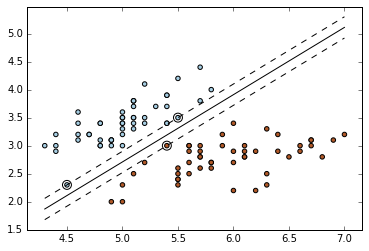

[2 1]
Rotation 1 . Rotating the left. Margin: 0.332718


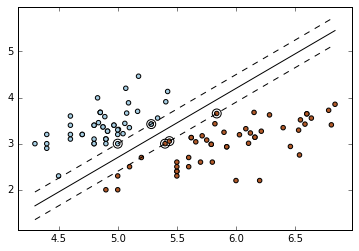

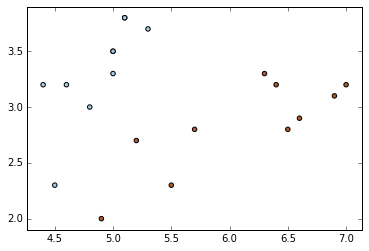

Test set : 1


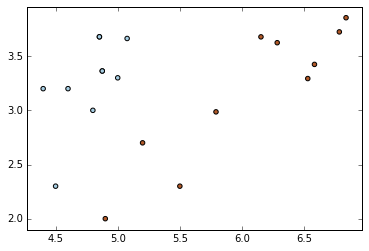

Without Rotation : Dataset 0. Margin: 0.243245 . Accuracy: 1.000000
One rotation : Dataset 1. Margin: 0.332718 . Accuracy: 1.000000


In [109]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import math
import pandas as pd
from sklearn import datasets
from random import randint
from matplotlib.backends.backend_pdf import PdfPages
import time
from pylab import *

iterations = 1
# nu = 0.002
# C = 100000

# Training set: X, y (80%)
# Test set: 20 % of that, random
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target
X= X[y!=2]
y = y[y!=2]
X[57][1] = 2

# clf = svm.NuSVC(kernel='linear', nu=nu)
# clf = svm.SVC(kernel='linear', C=C)
clf = get_clf()
clf.fit(X, y)
print clf.n_support_


# Test set
# Primeros 10, ultimos 10
x_test = X[40:60,:]
y_test = y[40:60]



datasets, accuracy_results = simulation(X, y, iterations, x_test, y_test, should_plot=True)




[2 1]


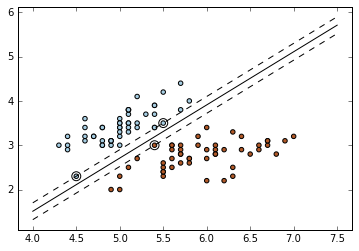

In [76]:
# Iris dataset 

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import math
import pandas as pd
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target
X = X[y!=2]
y = y[y!=2]
# print X
# print iris.target
# Modify one of the points to get a better SV:
# We modify the one indexed 57
X[57][1] = 2

clf = svm.SVC(kernel='linear', C=1000000)
clf.fit(X, y)
print clf.n_support_
# clf.support_vectors_

# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(4, 7.5)
yy = a * xx - (clf.intercept_[0]) / w[1]

# plot the parallels to the separating hyperplane that pass through the
# support vectors
b = clf.support_vectors_[0]
yy_down = a * xx + (b[1] - a * b[0])
b = clf.support_vectors_[-1]
yy_up = a * xx + (b[1] - a * b[0])

# plot the line, the points, and the nearest vectors to the plane
plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')

plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=80, facecolors='none')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)

plt.axis('tight')
plt.show()